In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from skimage.filters import gaussian
from scipy.ndimage import zoom, center_of_mass, shift, affine_transform
import cv2

import ipywidgets
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
#"ipyvtklink", "panel", "ipygany", "static", "pythreejs", "client", "server", "trame", "none"
pv.set_jupyter_backend("panel")

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
PIPELINE_ROOT = Path('./').absolute().parents[1]
PIPELINE_ROOT = PIPELINE_ROOT.as_posix()
sys.path.append(PIPELINE_ROOT)
print(PIPELINE_ROOT)

data_path = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data'
from library.atlas.atlas_utilities import register_volume, adjust_volume, affine_transform_volume, \
    affine_transform_point

/home/eddyod/programming/pipeline/src


In [17]:
def visualize_slices(volume, title="Slice View"):
    """Visualize the middle slices of a 3D volume."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    mid_slices = [s // 2 for s in volume.shape]
    
    axes[0].imshow(volume[mid_slices[0], :, :], cmap='gray')
    axes[0].set_title("Axial Slice")
    axes[1].imshow(volume[:, mid_slices[1], :], cmap='gray')
    axes[1].set_title("Coronal Slice")
    axes[2].imshow(volume[:, :, mid_slices[2]], cmap='gray')
    axes[2].set_title("Sagittal Slice")
    
    for ax in axes:
        ax.axis("on")
    plt.suptitle(title)
    plt.show()

def get_clockwise_edge_coords(array):
    # Ensure the array is binary (non-zero becomes 1)
    binary = (array > 0).astype(np.uint8)
    
    # Use skimage's find_contours to detect contours at level 0.5
    contours = measure.find_contours(binary, 0.5)

    # If multiple contours, take the largest (most points)
    if not contours:
        return []
    contour = max(contours, key=len)

    # Convert (row, col) to (x, y) and round to int
    coords = np.fliplr(contour).astype(int)

    # Ensure clockwise order using signed area (shoelace formula)
    def is_clockwise(pts):
        return np.sum(
            (pts[1:, 0] - pts[:-1, 0]) * (pts[1:, 1] + pts[:-1, 1])
        ) > 0

    if not is_clockwise(coords):
        coords = coords[::-1]  # Reverse if not clockwise

    return coords


def get_evenly_spaced_vertices(mask, num_points):
    """
    Given a binary mask, extract the outer contour and return evenly spaced vertices along the edge.

    Parameters:
    - mask: 2D numpy array (binary mask)
    - num_points: Number of evenly spaced points to return

    Returns:
    - List of (x, y) coordinates of vertices
    """
    # Ensure mask is uint8
    mask = mask.astype(np.uint8)

    # Find contours (external only)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return []

    # Choose the largest contour (in case there are multiple)
    contour = max(contours, key=cv2.contourArea).squeeze()

    # Calculate arc length (perimeter)
    arc_length = cv2.arcLength(contour, True)
    print(arc_length)

    # Calculate the cumulative arc lengths
    distances = [0]
    for i in range(1, len(contour)):
        d = np.linalg.norm(contour[i] - contour[i - 1])
        distances.append(distances[-1] + d)
    distances = np.array(distances)

    # Sample points at regular intervals
    desired_distances = np.linspace(0, distances[-1], num_points, endpoint=False)
    vertices = []
    j = 0
    for d in desired_distances:
        while j < len(distances) - 1 and distances[j+1] < d:
            j += 1
        # Linear interpolation between points j and j+1
        t = (d - distances[j]) / (distances[j+1] - distances[j])
        pt = (1 - t) * contour[j] + t * contour[j + 1]
        vertices.append(tuple(pt.astype(int)))

    return vertices

In [18]:
structure = 'SC'
animal = 'Allen'
structure_path = os.path.join(data_path, animal, 'structure', f'{structure}.npy')
arr = np.load(structure_path)
ids, counts = np.unique(arr, return_counts=True)
print(ids)
print(counts)
print(arr.shape, arr.dtype, np.mean(arr), np.min(arr), np.max(arr))

[  0 851]
[9781561 3890817]
(211, 179, 362) uint32 242.17332690772594 0 851


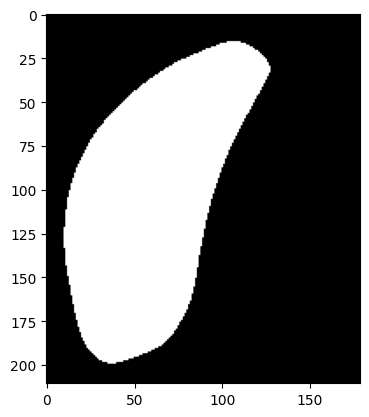

In [19]:
z = arr.shape[2] // 2
volume = arr.copy()
#volume = adjust_volume(volume, 255)
slice = volume[:,:,z].astype(np.uint32)
plt.imshow(slice, cmap='gray')

498.0731556415558


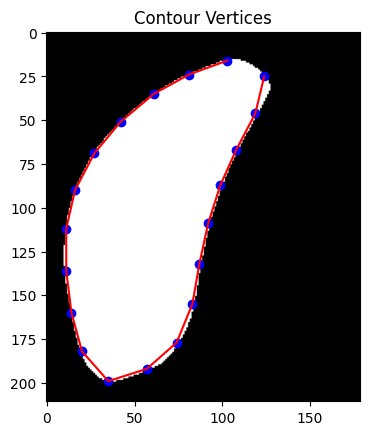

In [20]:
#n, nl, vertices = get_outer_edge_vertices(slice)
vertices = get_evenly_spaced_vertices(slice, 20)
# Visualize result
plt.imshow(slice, cmap='gray')
x, y = zip(*vertices)
plt.plot(x, y, 'r-')
plt.scatter(x, y, c='blue')
plt.title("Contour Vertices")
plt.show()

In [14]:
slice = volume[:,:,z].astype(np.uint32)
print(volume.shape)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
data = pv.wrap(volume)
data.plot(volume=True) # Volume render

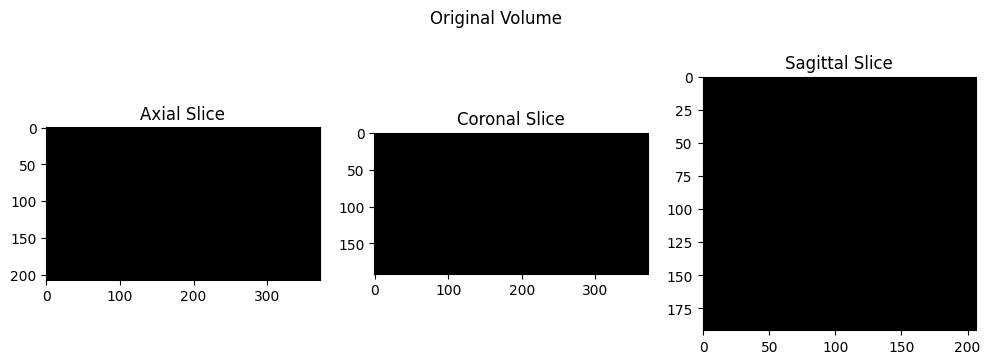

NameError: name 'transformed_volume' is not defined

In [15]:
#transformed_volume = affine_transform_volume(volume, transformation_matrix)
# Visualize original and transformed volumes
visualize_slices(volume, title="Original Volume")
visualize_slices(transformed_volume, title="Transformed Volume")